In [ ]:
! pip install -q kaggle

In [ ]:
 from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmednehad14","key":"479f0fc1e8a19cd1e283e98ba71e2289"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                                title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/apple-quality                                     Apple Quality                                      170KB  2024-01-11 14:31:07           6220        145  1.0              
hummaamqaasim/jobs-in-data                                         Jobs and Salaries in Data Science                   76KB  2023-12-25 20:03:32          12552        232  1.0              
emirhanai/city-happiness-index-2024                                City Happiness Index - 2024                          8KB  2024-01-22 00:41:50           1492         32  1.0              
shiivvvaam/revenue-of-top-companies-in-india      

In [ ]:
! kaggle competitions download -c 'predict-energy-behavior-of-prosumers'

 98% 227M/233M [00:01<00:00, 213MB/s]
100% 233M/233M [00:01<00:00, 166MB/s]


In [ ]:
!unzip /content/predict-energy-behavior-of-prosumers.zip -d /content/data

Archive:  /content/predict-energy-behavior-of-prosumers.zip
  inflating: /content/data/client.csv  
  inflating: /content/data/county_id_to_name_map.json  
  inflating: /content/data/electricity_prices.csv  
  inflating: /content/data/enefit/__init__.py  
  inflating: /content/data/enefit/competition.cpython-310-x86_64-linux-gnu.so  
  inflating: /content/data/example_test_files/client.csv  
  inflating: /content/data/example_test_files/electricity_prices.csv  
  inflating: /content/data/example_test_files/forecast_weather.csv  
  inflating: /content/data/example_test_files/gas_prices.csv  
  inflating: /content/data/example_test_files/historical_weather.csv  
  inflating: /content/data/example_test_files/revealed_targets.csv  
  inflating: /content/data/example_test_files/sample_submission.csv  
  inflating: /content/data/example_test_files/test.csv  
  inflating: /content/data/forecast_weather.csv  
  inflating: /content/data/gas_prices.csv  
  inflating: /content/data/historical_wea

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/data/train.csv')
df.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county              int64  
 1   is_business         int64  
 2   product_type        int64  
 3   target              float64
 4   is_consumption      int64  
 5   datetime            object 
 6   data_block_id       int64  
 7   row_id              int64  
 8   prediction_unit_id  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 138.6+ MB


In [ ]:
df.describe()

,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id
count,2.018352e+06,2.018352e+06,2.018352e+06,2.017824e+06,2018352.0,2.018352e+06,2.018352e+06,2.018352e+06
mean,7.297034e+00,5.368261e-01,1.898927e+00,2.748556e+02,0.5,3.218746e+02,1.009176e+06,3.304538e+01
std,4.780990e+00,4.986421e-01,1.081766e+00,9.095024e+02,0.5,1.826343e+02,5.826482e+05,1.959059e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,0.000000e+00,1.000000e+00,3.780000e-01,0.0,1.660000e+02,5.045878e+05,1.600000e+01
50%,7.000000e+00,1.000000e+00,2.000000e+00,3.113300e+01,0.5,3.230000e+02,1.009176e+06,3.300000e+01
75%,1.100000e+01,1.000000e+00,3.000000e+00,1.802062e+02,1.0,4.790000e+02,1.513763e+06,5.000000e+01
max,1.500000e+01,1.000000e+00,3.000000e+00,1.548027e+04,1.0,6.370000e+02,2.018351e+06,6.800000e+01


# checking for nulls

In [ ]:
df.isna().sum()

county                  0
is_business             0
product_type            0
target                528
is_consumption          0
datetime                0
data_block_id           0
row_id                  0
prediction_unit_id      0
dtype: int64

In [ ]:
df.dropna(inplace = True)

In [ ]:
df.isna().sum()

county                0
is_business           0
product_type          0
target                0
is_consumption        0
datetime              0
data_block_id         0
row_id                0
prediction_unit_id    0
dtype: int64

# Check for the duplicates

In [ ]:
df.duplicated().sum()

0

# number of unique values in each column

In [ ]:
df['date'] = pd.to_datetime(df['datetime'] ,  format='%Y-%m-%d %H:%M:%S' , utc = True)

df.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021-09-01 00:00:00+00:00
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,2021-09-01 00:00:00+00:00
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,2021-09-01 00:00:00+00:00
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,2021-09-01 00:00:00+00:00
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,2021-09-01 00:00:00+00:00


In [ ]:
data = df[['county' , 'product_type' , 'is_business' , 'is_consumption' , 'date' , 'target']]
data.head()

,county,product_type,is_business,is_consumption,date,target
0,0,1,0,0,2021-09-01 00:00:00+00:00,0.713
1,0,1,0,1,2021-09-01 00:00:00+00:00,96.590
2,0,2,0,0,2021-09-01 00:00:00+00:00,0.000
3,0,2,0,1,2021-09-01 00:00:00+00:00,17.314
4,0,3,0,0,2021-09-01 00:00:00+00:00,2.904


In [ ]:
data['hour'] = data['date'].dt.hour
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data.head()

,county,product_type,is_business,is_consumption,date,target,hour,day,month,year
0,0,1,0,0,2021-09-01 00:00:00+00:00,0.713,0,1,9,2021
1,0,1,0,1,2021-09-01 00:00:00+00:00,96.590,0,1,9,2021
2,0,2,0,0,2021-09-01 00:00:00+00:00,0.000,0,1,9,2021
3,0,2,0,1,2021-09-01 00:00:00+00:00,17.314,0,1,9,2021
4,0,3,0,0,2021-09-01 00:00:00+00:00,2.904,0,1,9,2021


In [ ]:
data.drop('date' , inplace = True , axis = 1)

In [ ]:
data.head()

,county,product_type,is_business,is_consumption,target,hour,day,month,year
0,0,1,0,0,0.713,0,1,9,2021
1,0,1,0,1,96.590,0,1,9,2021
2,0,2,0,0,0.000,0,1,9,2021
3,0,2,0,1,17.314,0,1,9,2021
4,0,3,0,0,2.904,0,1,9,2021


In [ ]:
consumption_df = data[data['is_consumption'] == 1].drop('is_consumption' , axis = 1)
consumption_df.head()

,county,product_type,is_business,target,hour,day,month,year
1,0.0,0.333333,0.0,96.590,0.0,0.0,0.727273,0.0
3,0.0,0.666667,0.0,17.314,0.0,0.0,0.727273,0.0
5,0.0,1.000000,0.0,656.859,0.0,0.0,0.727273,0.0
7,0.0,0.000000,1.0,59.000,0.0,0.0,0.727273,0.0
9,0.0,0.333333,1.0,501.760,0.0,0.0,0.727273,0.0


In [ ]:
producing_df = data[data['is_consumption'] == 0].drop('is_consumption' , axis = 1)
producing_df.tail()

,county,product_type,is_business,target,hour,day,month,year
2018342,1.0,0.333333,0.0,0.004,1.0,1.0,0.363636,1.0
2018344,1.0,1.000000,0.0,2.287,1.0,1.0,0.363636,1.0
2018346,1.0,0.000000,1.0,0.000,1.0,1.0,0.363636,1.0
2018348,1.0,0.333333,1.0,0.000,1.0,1.0,0.363636,1.0
2018350,1.0,1.000000,1.0,0.000,1.0,1.0,0.363636,1.0


## Data visualization

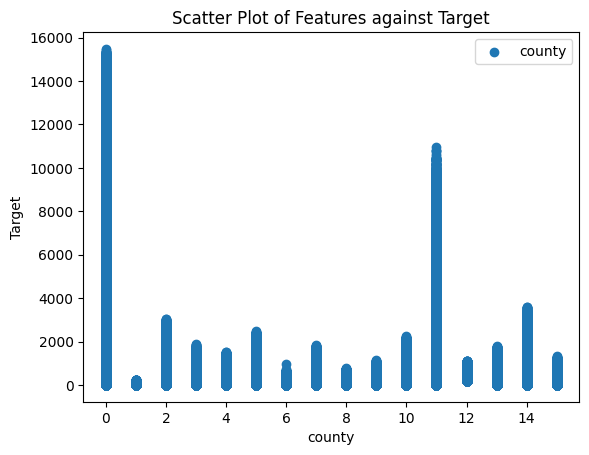

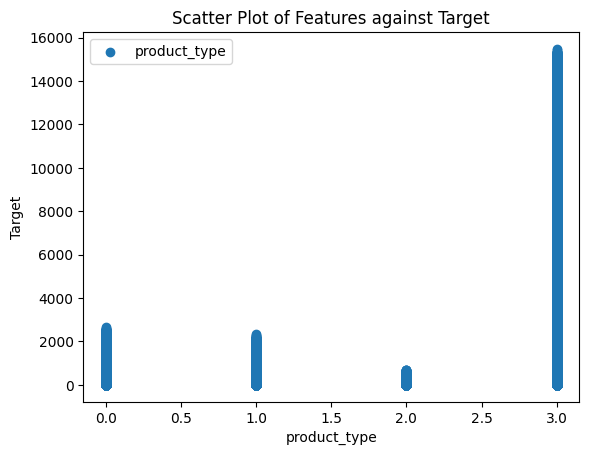

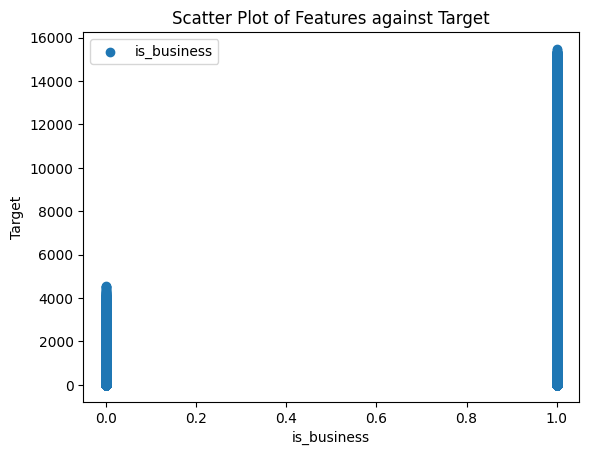

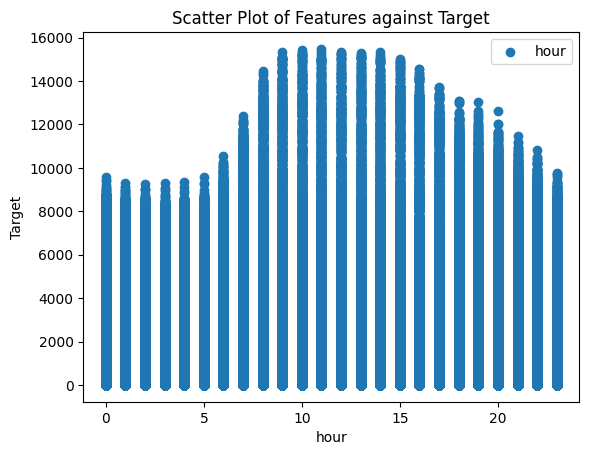

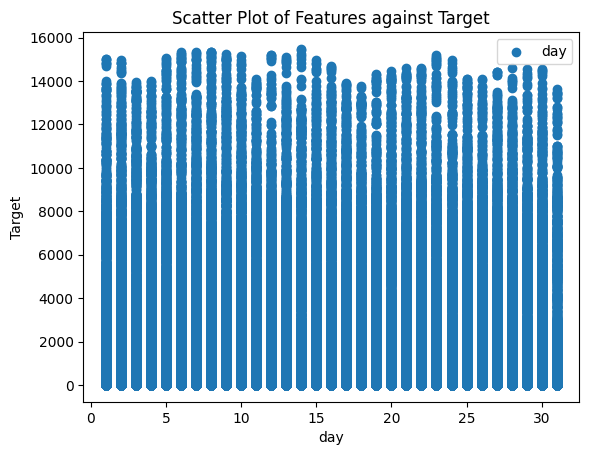

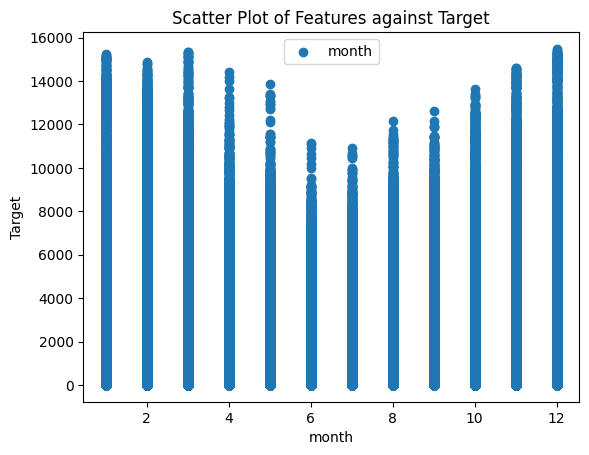

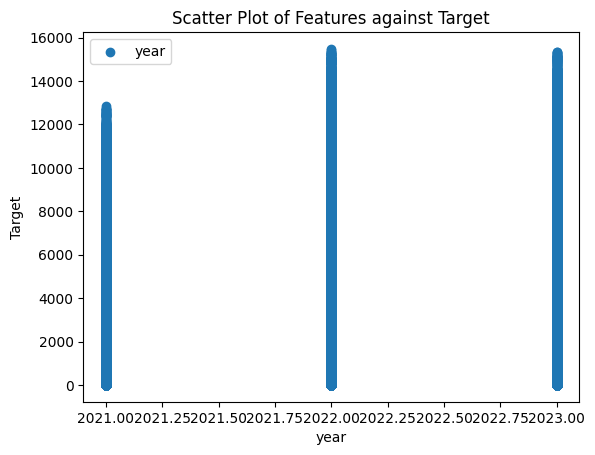

In [ ]:
features = [col for col in consumption_df.columns if col != 'target']

for feature in features:
    plt.scatter(consumption_df[feature], consumption_df['target'], label=feature)
    plt.xlabel(feature)
    plt.ylabel('Target')
    plt.title('Scatter Plot of Features against Target')
    plt.legend()
    plt.show()

# Model for the consumption

feature selecting

In [ ]:
# Separate features and target variable
X = consumption_df.drop('target' , axis = 1)
y = consumption_df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Correlation analysis
correlation_matrix = consumption_df.corr()
correlation_with_target = correlation_matrix['target'].abs().sort_values(ascending=False)
significant_features_corr = correlation_with_target[correlation_with_target > 0.2].index.tolist()

# Feature importance analysis using a tree-based model (Random Forest)
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Select top k features based on importance
k = 2  # You can adjust the number of features to select
top_features_rf = X.columns[feature_importances.argsort()[-k:][::-1]]

# Print the results
print("Significant Features (Correlation Analysis):", significant_features_corr)
print("Top Features (Random Forest):", top_features_rf)


Significant Features (Correlation Analysis): ['target', 'is_business', 'product_type']
Top Features (Random Forest): Index(['product_type', 'county'], dtype='object')


In [ ]:
X = consumption_df.drop('target' , axis = 1)
y = consumption_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

In [ ]:
# Create an XGBoost regression model
xg_reg_c = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
xg_reg_c.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = xg_reg_c.predict(X_train)

# Make predictions on the testing set
y_test_pred = xg_reg_c.predict(X_test)

# Calculate mean absolute error for training and testing sets
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Calculate mean squared error for training and testing sets
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Calculate R-squared for training and testing sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the results
print(f'Mean Absolute Error (Training): {mae_train:.2f}')
print(f'Mean Absolute Error (Testing): {mae_test:.2f}')
print(f'Mean Squared Error (Training): {mse_train:.2f}')
print(f'Mean Squared Error (Testing): {mse_test:.2f}')
print(f'R-squared (Training): {r2_train}')
print(f'R-squared (Testing): {r2_test}')

Mean Absolute Error (Training): 105.77
Mean Absolute Error (Testing): 106.45
Mean Squared Error (Training): 66827.59
Mean Squared Error (Testing): 67582.18
R-squared (Training): 0.9535013303275115
R-squared (Testing): 0.9530068716234


In [ ]:
xg_reg_c.save_model('consumption model.model')

In [ ]:
import pickle

# Save the XGBoost model
model_filename = 'consumption_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(xg_reg_c, file)

print(f'Model saved as {model_filename}')


Model saved as consumption_model.pkl


In [ ]:
# Define the LightGBM regression model with default parameters
lgb_reg_c = lgb.LGBMRegressor(objective='regression', random_state=42)

# Train the model
lgb_reg_c.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = lgb_reg_c.predict(X_train)

# Make predictions on the testing set
y_test_pred = lgb_reg_c.predict(X_test)

# Calculate metrics for the training set
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Calculate metrics for the testing set
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the results for training set
print('\nTraining Set Metrics:')
print(f'Mean Absolute Error (Training): {mae_train:.2f}')
print(f'Mean Squared Error (Training): {mse_train:.2f}')
print(f'R-squared (Training): {r2_train}')

# Print the results for testing set
print('\nTesting Set Metrics:')
print(f'Mean Absolute Error (Testing): {mae_test:.2f}')
print(f'Mean Squared Error (Testing): {mse_test:.2f}')
print(f'R-squared (Testing): {r2_test}')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 92
[LightGBM] [Info] Number of data points in the train set: 706238, number of used features: 7
[LightGBM] [Info] Start training from score 460.312375

Training Set Metrics:
Mean Absolute Error (Training): 115.66
Mean Squared Error (Training): 73079.70
R-squared (Training): 0.9491511101744555

Testing Set Metrics:
Mean Absolute Error (Testing): 116.01
Mean Squared Error (Testing): 74111.49
R-squared (Testing): 0.9484667349773013


# Model for production

In [ ]:
# Separate features and target variable
X = producing_df.drop('target' , axis = 1)
y = producing_df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Correlation analysis
correlation_matrix = producing_df.corr()
correlation_with_target = correlation_matrix['target'].abs().sort_values(ascending=False)
significant_features_corr = correlation_with_target[correlation_with_target > 0.2].index.tolist()

# Feature importance analysis using a tree-based model (Random Forest)
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Select top k features based on importance
k = 2  # You can adjust the number of features to select
top_features_rf = X.columns[feature_importances.argsort()[-k:][::-1]]

# Print the results
print("Significant Features (Correlation Analysis):", significant_features_corr)
print("Top Features (Random Forest):", top_features_rf)

Significant Features (Correlation Analysis): ['target']
Top Features (Random Forest): Index(['month', 'county'], dtype='object')


In [ ]:
X = producing_df.drop('target' , axis = 1)
y = producing_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

In [ ]:
# Create an XGBoost regression model
xg_reg_p = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
xg_reg_p.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = xg_reg_p.predict(X_train)

# Make predictions on the testing set
y_test_pred = xg_reg_p.predict(X_test)

# Calculate mean absolute error for training and testing sets
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Calculate mean squared error for training and testing sets
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Calculate R-squared for training and testing sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the results
print(f'Mean Absolute Error (Training): {mae_train:.2f}')
print(f'Mean Absolute Error (Testing): {mae_test:.2f}')
print(f'Mean Squared Error (Training): {mse_train:.2f}')
print(f'Mean Squared Error (Testing): {mse_test:.2f}')
print(f'R-squared (Training): {r2_train}')
print(f'R-squared (Testing): {r2_test}')

Mean Absolute Error (Training): 56.42
Mean Absolute Error (Testing): 56.48
Mean Squared Error (Training): 28475.78
Mean Squared Error (Testing): 27756.70
R-squared (Training): 0.8089495339710755
R-squared (Testing): 0.8085619909106103


In [ ]:
# Define the LightGBM regression model with default parameters
lgb_reg_p = lgb.LGBMRegressor(objective='regression', random_state=42)

# Train the model
lgb_reg_p.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = lgb_reg_p.predict(X_train)

# Make predictions on the testing set
y_test_pred = lgb_reg_p.predict(X_test)

# Calculate metrics for the training set
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Calculate metrics for the testing set
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the results for training set
print('\nTraining Set Metrics:')
print(f'Mean Absolute Error (Training): {mae_train:.2f}')
print(f'Mean Squared Error (Training): {mse_train:.2f}')
print(f'R-squared (Training): {r2_train}')

# Print the results for testing set
print('\nTesting Set Metrics:')
print(f'Mean Absolute Error (Testing): {mae_test:.2f}')
print(f'Mean Squared Error (Testing): {mse_test:.2f}')
print(f'R-squared (Testing): {r2_test}')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 92
[LightGBM] [Info] Number of data points in the train set: 706238, number of used features: 7
[LightGBM] [Info] Start training from score 89.372450

Training Set Metrics:
Mean Absolute Error (Training): 45.28
Mean Squared Error (Training): 21304.11
R-squared (Training): 0.8570659135503075

Testing Set Metrics:
Mean Absolute Error (Testing): 45.19
Mean Squared Error (Testing): 21359.16
R-squared (Testing): 0.8526858463591028


In [ ]:
lgb_reg_p.save_model('production model.model')

AttributeError: 'LGBMRegressor' object has no attribute 'save_model'

In [ ]:
# Save the LightGBM model
model_filename_lgb = 'production_model.pkl'
with open(model_filename_lgb, 'wb') as file:
    pickle.dump(lgb_reg_p, file)

print(f'Model saved as {model_filename_lgb}')

Model saved as production_model.pkl


# Test output

In [ ]:
tdf = pd.read_csv('/content/data/example_test_files/test.csv')
tdf.head()

,county,is_business,product_type,is_consumption,prediction_datetime,data_block_id,row_id,prediction_unit_id,currently_scored
0,0,0,1,0,2023-05-28 00:00:00,634,2005872,0,False
1,0,0,1,1,2023-05-28 00:00:00,634,2005873,0,False
2,0,0,2,0,2023-05-28 00:00:00,634,2005874,1,False
3,0,0,2,1,2023-05-28 00:00:00,634,2005875,1,False
4,0,0,3,0,2023-05-28 00:00:00,634,2005876,2,False


In [ ]:
tdf['DT'] = pd.to_datetime(tdf['prediction_datetime'] ,  format='%Y-%m-%d %H:%M:%S' , utc = True)
tdf.head()

,county,is_business,product_type,is_consumption,prediction_datetime,data_block_id,row_id,prediction_unit_id,currently_scored,DT
0,0,0,1,0,2023-05-28 00:00:00,634,2005872,0,False,2023-05-28 00:00:00+00:00
1,0,0,1,1,2023-05-28 00:00:00,634,2005873,0,False,2023-05-28 00:00:00+00:00
2,0,0,2,0,2023-05-28 00:00:00,634,2005874,1,False,2023-05-28 00:00:00+00:00
3,0,0,2,1,2023-05-28 00:00:00,634,2005875,1,False,2023-05-28 00:00:00+00:00
4,0,0,3,0,2023-05-28 00:00:00,634,2005876,2,False,2023-05-28 00:00:00+00:00


In [ ]:
tdf['hour'] = tdf['DT'].dt.hour
tdf['day'] = tdf['DT'].dt.day
tdf['month'] = tdf['DT'].dt.month
tdf['year'] = tdf['DT'].dt.year
tdf.head()

,county,is_business,product_type,is_consumption,prediction_datetime,data_block_id,row_id,prediction_unit_id,currently_scored,DT,hour,day,month,year
0,0,0,1,0,2023-05-28 00:00:00,634,2005872,0,False,2023-05-28 00:00:00+00:00,0,28,5,2023
1,0,0,1,1,2023-05-28 00:00:00,634,2005873,0,False,2023-05-28 00:00:00+00:00,0,28,5,2023
2,0,0,2,0,2023-05-28 00:00:00,634,2005874,1,False,2023-05-28 00:00:00+00:00,0,28,5,2023
3,0,0,2,1,2023-05-28 00:00:00,634,2005875,1,False,2023-05-28 00:00:00+00:00,0,28,5,2023
4,0,0,3,0,2023-05-28 00:00:00,634,2005876,2,False,2023-05-28 00:00:00+00:00,0,28,5,2023


In [ ]:
tdfp = tdf[tdf['is_consumption'] == 0]
tdfp['predictions'] = lgb_reg_p.predict(tdfp[['county',	'product_type', 'is_business',	'hour',	'day',	'month',	'year']])
tdfp.head()

,county,is_business,product_type,is_consumption,prediction_datetime,data_block_id,row_id,prediction_unit_id,currently_scored,DT,hour,day,month,year,predictions
0,0,0,1,0,2023-05-28 00:00:00,634,2005872,0,False,2023-05-28 00:00:00+00:00,0,28,5,2023,13.737664
2,0,0,2,0,2023-05-28 00:00:00,634,2005874,1,False,2023-05-28 00:00:00+00:00,0,28,5,2023,10.259178
4,0,0,3,0,2023-05-28 00:00:00,634,2005876,2,False,2023-05-28 00:00:00+00:00,0,28,5,2023,51.081648
6,0,1,0,0,2023-05-28 00:00:00,634,2005878,3,False,2023-05-28 00:00:00+00:00,0,28,5,2023,8.090096
8,0,1,1,0,2023-05-28 00:00:00,634,2005880,4,False,2023-05-28 00:00:00+00:00,0,28,5,2023,8.090096


In [ ]:
tdfp.drop(['DT' , 'hour' , 'month' , 'year' , 'day'] , axis = 1 , inplace = True)
tdfp.tail()

,county,is_business,product_type,is_consumption,prediction_datetime,data_block_id,row_id,prediction_unit_id,currently_scored,predictions
12470,15,0,1,0,2023-05-31 23:00:00,637,2018342,57,False,9.144660
12472,15,0,3,0,2023-05-31 23:00:00,637,2018344,58,False,14.822850
12474,15,1,0,0,2023-05-31 23:00:00,637,2018346,64,False,10.312210
12476,15,1,1,0,2023-05-31 23:00:00,637,2018348,59,False,11.286167
12478,15,1,3,0,2023-05-31 23:00:00,637,2018350,60,False,16.786711


In [ ]:
tdfc = tdf[tdf['is_consumption'] == 1]
tdfc['predictions'] = xg_reg_c.predict(tdfc[['county',	'product_type', 'is_business',	'hour',	'day',	'month',	'year']])
tdfc.head()

,county,is_business,product_type,is_consumption,prediction_datetime,data_block_id,row_id,prediction_unit_id,currently_scored,DT,hour,day,month,year,predictions
1,0,0,1,1,2023-05-28 00:00:00,634,2005873,0,False,2023-05-28 00:00:00+00:00,0,28,5,2023,447.422424
3,0,0,2,1,2023-05-28 00:00:00,634,2005875,1,False,2023-05-28 00:00:00+00:00,0,28,5,2023,-28.790075
5,0,0,3,1,2023-05-28 00:00:00,634,2005877,2,False,2023-05-28 00:00:00+00:00,0,28,5,2023,1383.248535
7,0,1,0,1,2023-05-28 00:00:00,634,2005879,3,False,2023-05-28 00:00:00+00:00,0,28,5,2023,206.576782
9,0,1,1,1,2023-05-28 00:00:00,634,2005881,4,False,2023-05-28 00:00:00+00:00,0,28,5,2023,478.341980


In [ ]:
tdfc.drop(['DT' , 'hour' , 'month' , 'year' , 'day'] , axis = 1 , inplace = True)
tdfc.tail()

,county,is_business,product_type,is_consumption,prediction_datetime,data_block_id,row_id,prediction_unit_id,currently_scored,predictions
12471,15,0,1,1,2023-05-31 23:00:00,637,2018343,57,False,41.771767
12473,15,0,3,1,2023-05-31 23:00:00,637,2018345,58,False,128.139236
12475,15,1,0,1,2023-05-31 23:00:00,637,2018347,64,False,368.877228
12477,15,1,1,1,2023-05-31 23:00:00,637,2018349,59,False,90.622459
12479,15,1,3,1,2023-05-31 23:00:00,637,2018351,60,False,276.821808


In [ ]:
# Append df2 to df1
appended_df = tdfc.append(tdfp)

# Sort the dataframe by index
sorted_appended_df = appended_df.sort_index()


sorted_appended_df.head(10)

,county,is_business,product_type,is_consumption,prediction_datetime,data_block_id,row_id,prediction_unit_id,currently_scored,DT,hour,day,month,year,predictions
0,0,0,1,0,2023-05-28 00:00:00,634,2005872,0,False,2023-05-28 00:00:00+00:00,0,28,5,2023,13.737664
1,0,0,1,1,2023-05-28 00:00:00,634,2005873,0,False,2023-05-28 00:00:00+00:00,0,28,5,2023,447.422424
2,0,0,2,0,2023-05-28 00:00:00,634,2005874,1,False,2023-05-28 00:00:00+00:00,0,28,5,2023,10.259178
3,0,0,2,1,2023-05-28 00:00:00,634,2005875,1,False,2023-05-28 00:00:00+00:00,0,28,5,2023,-28.790075
4,0,0,3,0,2023-05-28 00:00:00,634,2005876,2,False,2023-05-28 00:00:00+00:00,0,28,5,2023,51.081648
5,0,0,3,1,2023-05-28 00:00:00,634,2005877,2,False,2023-05-28 00:00:00+00:00,0,28,5,2023,1383.248535
6,0,1,0,0,2023-05-28 00:00:00,634,2005878,3,False,2023-05-28 00:00:00+00:00,0,28,5,2023,8.090096
7,0,1,0,1,2023-05-28 00:00:00,634,2005879,3,False,2023-05-28 00:00:00+00:00,0,28,5,2023,206.576782
8,0,1,1,0,2023-05-28 00:00:00,634,2005880,4,False,2023-05-28 00:00:00+00:00,0,28,5,2023,8.090096
9,0,1,1,1,2023-05-28 00:00:00,634,2005881,4,False,2023-05-28 00:00:00+00:00,0,28,5,2023,478.341980


In [ ]:
sorted_appended_df.to_csv('models predictions.csv')

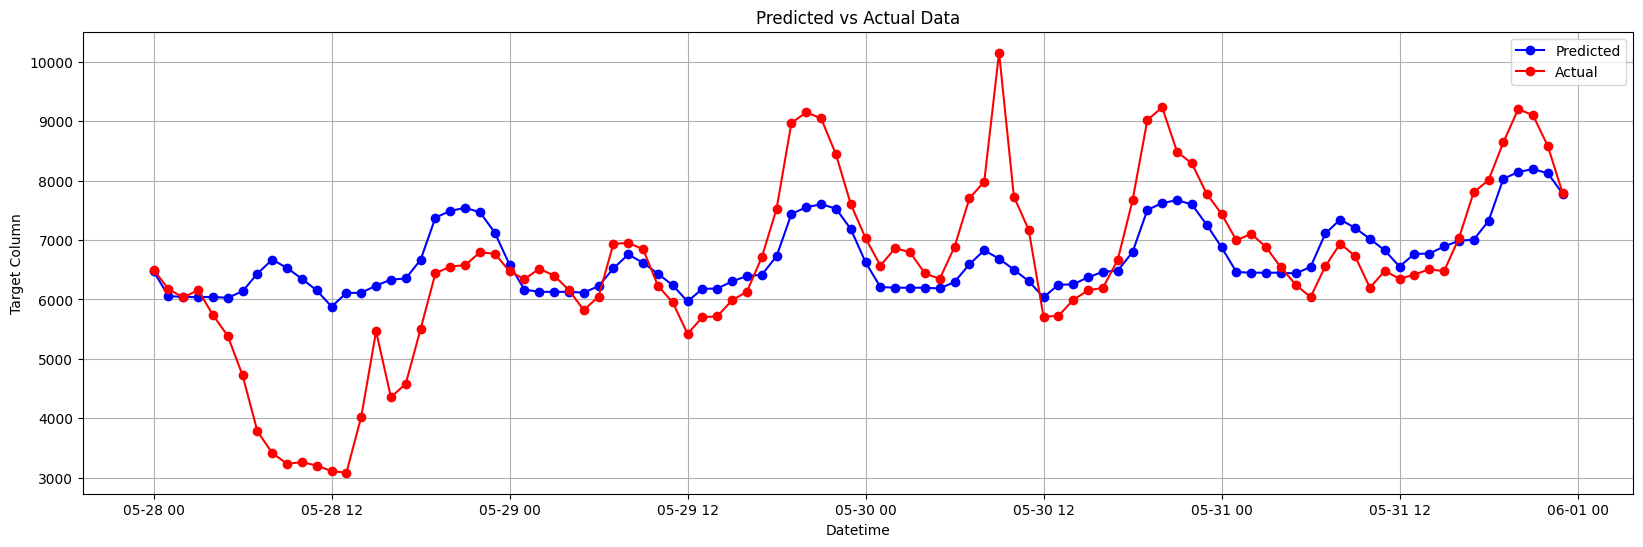

In [ ]:

# Plotting predicted data
plt.figure(figsize=(20, 6))
dff = sorted_appended_df[ (sorted_appended_df['prediction_unit_id'] == 5) & (sorted_appended_df['is_consumption'] == 1)]
dff = dff[ (dff['year'] == 2023) & (dff['month'] >= 5) & (dff['day'] >= 28)]

plt.plot(dff['DT'], dff['predictions'], marker='o', linestyle='-', color='b', label='Predicted')


dff = data[ (data['prediction_unit_id'] == 5) & (data['is_consumption'] == 1)]
dff = dff[ (dff['year'] == 2023) & (dff['month'] >= 5) & (dff['day'] >= 28)]

# Plotting actual data
plt.plot(dff['date'], dff['target'], marker='o', linestyle='-', color='r', label='Actual')

# Customize the plot
plt.title('Predicted vs Actual Data')
plt.xlabel('Datetime')
plt.ylabel('Target Column')
plt.grid(True)
plt.legend()  # Show legend to differentiate between predicted and actual data

# Show the plot
plt.show()


# Visualizing results

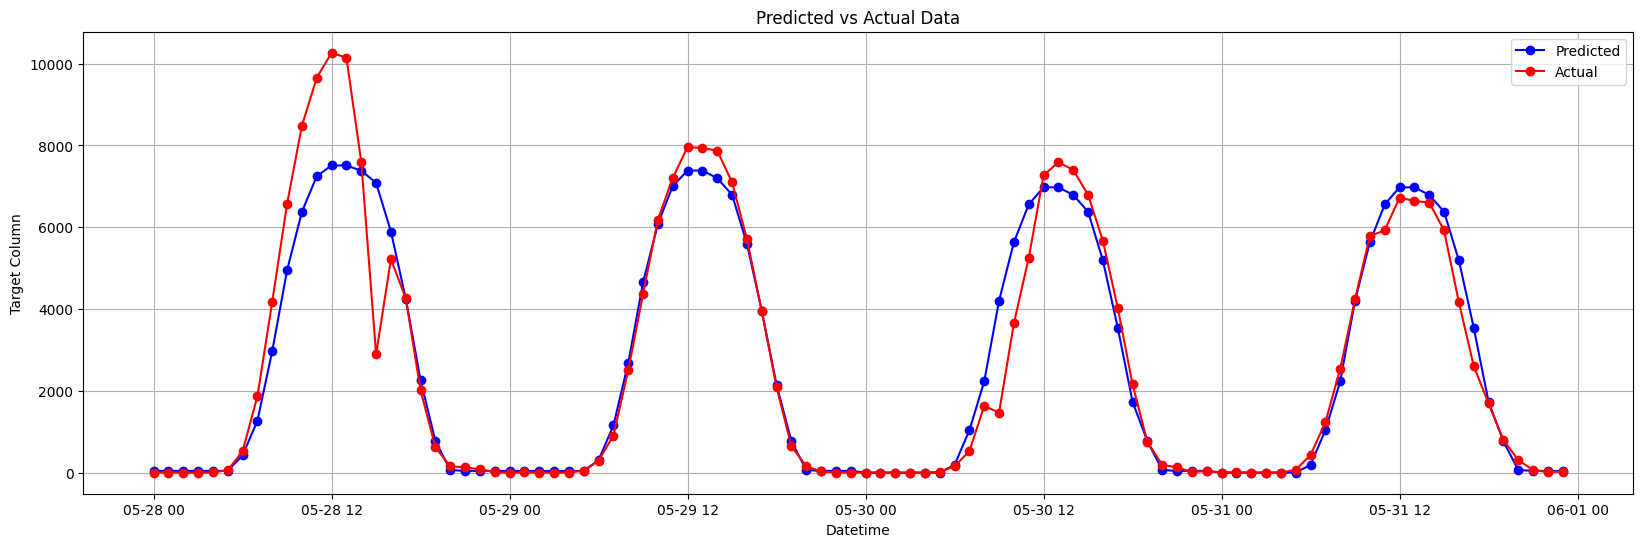

In [ ]:

# Plotting predicted data
plt.figure(figsize=(20, 6))
dff = sorted_appended_df[ (sorted_appended_df['prediction_unit_id'] == 5) & (sorted_appended_df['is_consumption'] == 0)]
dff = dff[ (dff['year'] == 2023) & (dff['month'] >= 5) & (dff['day'] >= 28)]
plt.plot(dff['DT'], dff['predictions'], marker='o', linestyle='-', color='b', label='Predicted')


dff = data[ (data['prediction_unit_id'] == 5) & (data['is_consumption'] == 0)]
dff = dff[ (dff['year'] == 2023) & (dff['month'] >= 5) & (dff['day'] >= 28)]

# Plotting actual data
plt.plot(dff['date'], dff['target'], marker='o', linestyle='-', color='r', label='Actual')

# Customize the plot
plt.title('Predicted vs Actual Data')
plt.xlabel('Datetime')
plt.ylabel('Target Column')
plt.grid(True)
plt.legend()  # Show legend to differentiate between predicted and actual data

# Show the plot
plt.show()


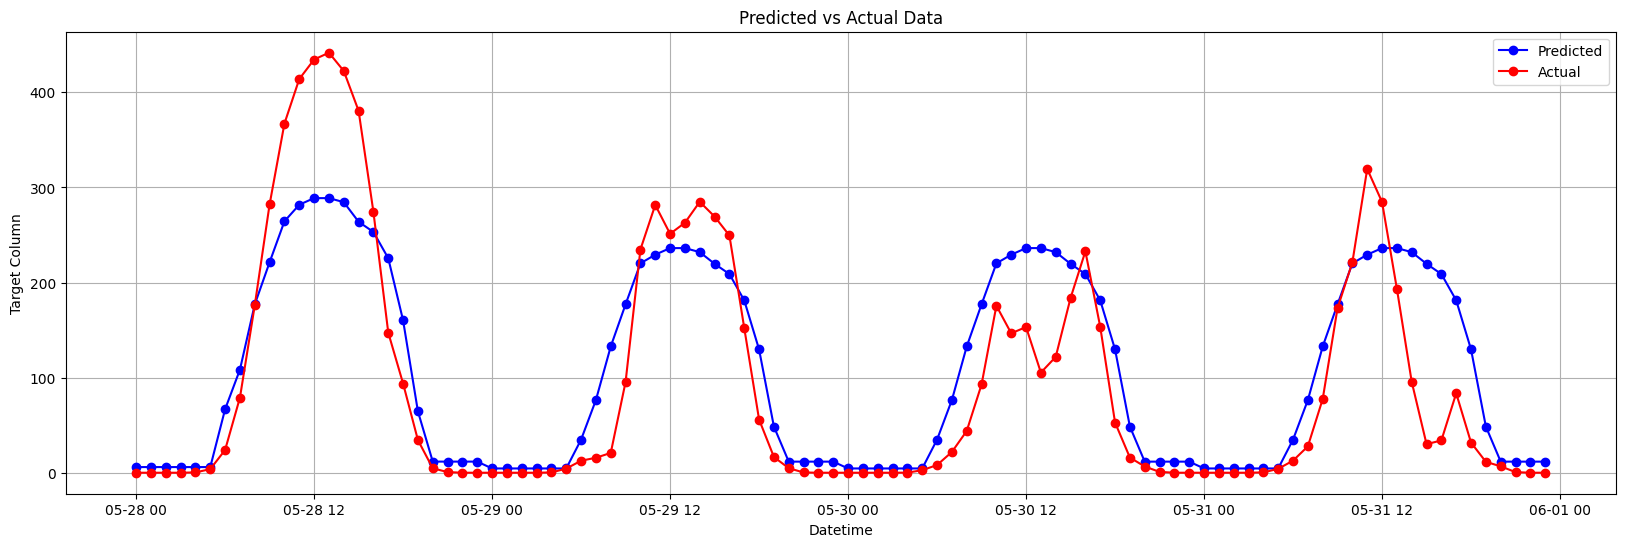

In [ ]:
# Plotting predicted data
plt.figure(figsize=(20, 6))
dff = sorted_appended_df[ (sorted_appended_df['prediction_unit_id'] == 22) & (sorted_appended_df['is_consumption'] == 0)]
dff = dff[ (dff['year'] == 2023) & (dff['month'] >= 5) & (dff['day'] >= 28)]


plt.plot(dff['DT'], dff['predictions'], marker='o', linestyle='-', color='b', label='Predicted')


dff = data[ (data['prediction_unit_id'] == 22) & (data['is_consumption'] == 0)]
dff = dff[ (dff['year'] == 2023) & (dff['month'] >= 5) & (dff['day'] >= 28)]

# Plotting actual data
plt.plot(dff['date'], dff['target'], marker='o', linestyle='-', color='r', label='Actual')

# Customize the plot
plt.title('Predicted vs Actual Data')
plt.xlabel('Datetime')
plt.ylabel('Target Column')
plt.grid(True)
plt.legend()  # Show legend to differentiate between predicted and actual data

# Show the plot
plt.show()


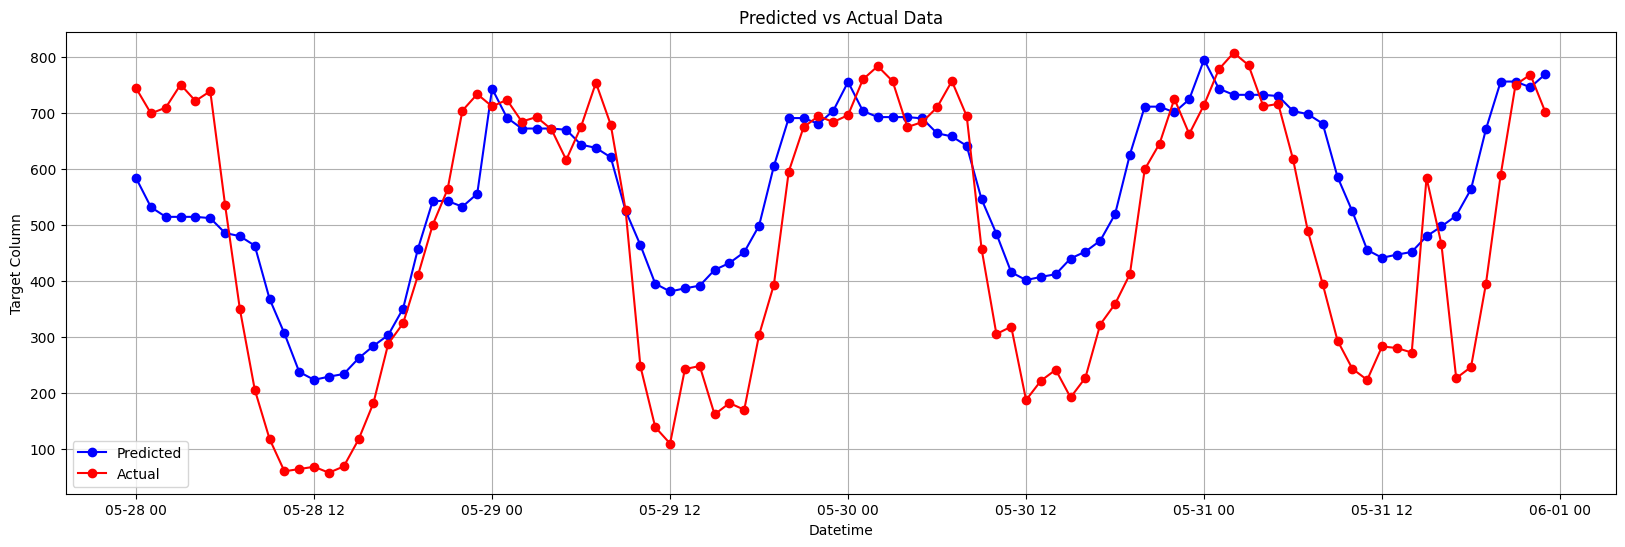

In [ ]:
# Plotting predicted data
plt.figure(figsize=(20, 6))
dff = sorted_appended_df[ (sorted_appended_df['prediction_unit_id'] == 14) & (sorted_appended_df['is_consumption'] == 1)]
dff = dff[ (dff['year'] == 2023) & (dff['month'] >= 5) & (dff['day'] >= 28)]


plt.plot(dff['DT'], dff['predictions'], marker='o', linestyle='-', color='b', label='Predicted')


dff = data[ (data['prediction_unit_id'] == 14) & (data['is_consumption'] == 1)]
dff = dff[ (dff['year'] == 2023) & (dff['month'] >= 5) & (dff['day'] >= 28)]

# Plotting actual data
plt.plot(dff['date'], dff['target'], marker='o', linestyle='-', color='r', label='Actual')

# Customize the plot
plt.title('Predicted vs Actual Data')
plt.xlabel('Datetime')
plt.ylabel('Target Column')
plt.grid(True)
plt.legend()  # Show legend to differentiate between predicted and actual data

# Show the plot
plt.show()


In [ ]:
X = data.drop('target' , axis = 1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

# Create an XGBoost regression model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
xg_reg.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = xg_reg.predict(X_train)

# Make predictions on the testing set
y_test_pred = xg_reg.predict(X_test)

# Calculate mean absolute error for training and testing sets
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Calculate mean squared error for training and testing sets
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Calculate R-squared for training and testing sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the results
print(f'Mean Absolute Error (Training): {mae_train:.2f}')
print(f'Mean Absolute Error (Testing): {mae_test:.2f}')
print(f'Mean Squared Error (Training): {mse_train:.2f}')
print(f'Mean Squared Error (Testing): {mse_test:.2f}')
print(f'R-squared (Training): {r2_train}')
print(f'R-squared (Testing): {r2_test}')

Mean Absolute Error (Training): 99.52
Mean Absolute Error (Testing): 99.86
Mean Squared Error (Training): 61756.70
Mean Squared Error (Testing): 62496.77
R-squared (Training): 0.92573696434701
R-squared (Testing): 0.9234976861552807


In [ ]:
# Define the LightGBM regression model with default parameters
lgb_reg_c = lgb.LGBMRegressor(objective='regression', random_state=42)

# Train the model
lgb_reg_c.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = lgb_reg_c.predict(X_train)

# Make predictions on the testing set
y_test_pred = lgb_reg_c.predict(X_test)

# Calculate metrics for the training set
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Calculate metrics for the testing set
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the results for training set
print('\nTraining Set Metrics:')
print(f'Mean Absolute Error (Training): {mae_train:.2f}')
print(f'Mean Squared Error (Training): {mse_train:.2f}')
print(f'R-squared (Training): {r2_train}')

# Print the results for testing set
print('\nTesting Set Metrics:')
print(f'Mean Absolute Error (Testing): {mae_test:.2f}')
print(f'Mean Squared Error (Testing): {mse_test:.2f}')
print(f'R-squared (Testing): {r2_test}')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 97
[LightGBM] [Info] Number of data points in the train set: 1412476, number of used features: 8
[LightGBM] [Info] Start training from score 275.216970

Training Set Metrics:
Mean Absolute Error (Training): 97.04
Mean Squared Error (Training): 59770.17
R-squared (Training): 0.9281257966122893

Testing Set Metrics:
Mean Absolute Error (Testing): 97.21
Mean Squared Error (Testing): 60585.96
R-squared (Testing): 0.9258367095318875
